In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import bpl
import wcpredictor

/Users/rchan/opt/miniconda3/envs/wcenv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Neutral Model, Results Since 2018 + FIFA Rankings

In [2]:
# results = wcpredictor.get_results_data(start_date="2018-01-01",
#                                        end_date="2022-11-01")
# fifa_rankings = wcpredictor.get_fifa_rankings_data()
wc_teams = wcpredictor.get_teams_data(year="2022")

# print(f"{sum(results['neutral'])} / {len(results)} games are neutral")

# wc_pred = wcpredictor.WCPred(results = results, ratings=fifa_rankings)

In [3]:
wc_pred = wcpredictor.get_and_train_model(rankings_source="game")
dict(zip(sorted(list(set(wcpredictor.get_confederations_data()["Confederation"]))),
         wc_pred.model.confederation_strength.mean(axis=0).tolist()))

in get_and_train_model
Using FIFA organisation rankings
Using 3728 rows in training data
Using FIFA videogame rankings
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|███████████████████████████████████████████████| 1500/1500 [03:03<00:00,  8.17it/s, 511 steps of size 8.07e-03. acc. prob=0.93]


{'AFC': -0.11179405450820923,
 'CAF': 0.27068543434143066,
 'CONCACAF': -0.21344220638275146,
 'CONMEBOL': 0.39800649881362915,
 'OFC': -0.4676389992237091,
 'UEFA': 0.11972488462924957}

In [4]:
wc_teams_idx = {team: idx for idx, team in enumerate(wc_pred.model.teams)
                if team in wc_teams["Team"].values}

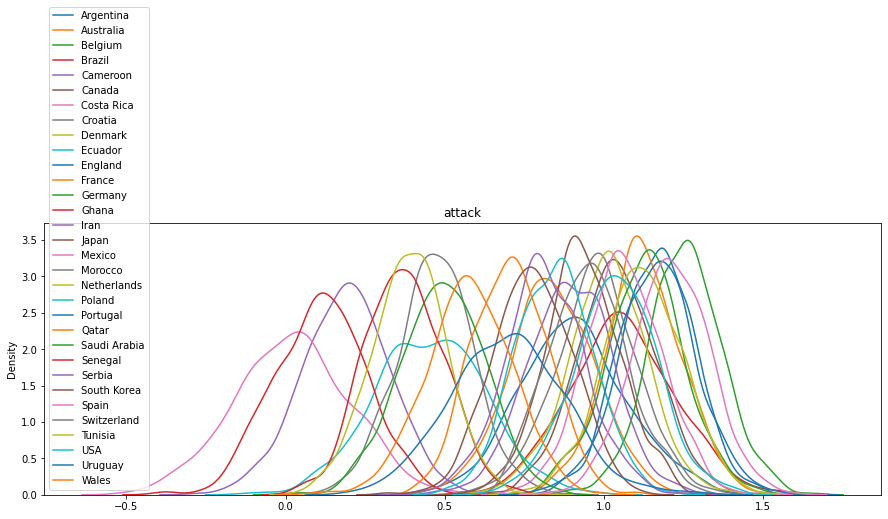

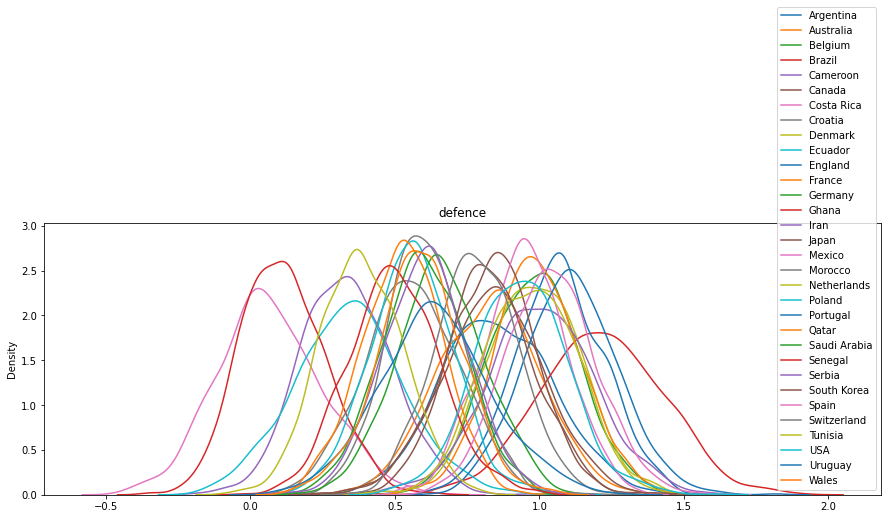

In [5]:
ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.attack[:, idx], label=team)
plt.title('attack')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.defence[:, idx], label=team)
plt.title('defence')
plt.legend()

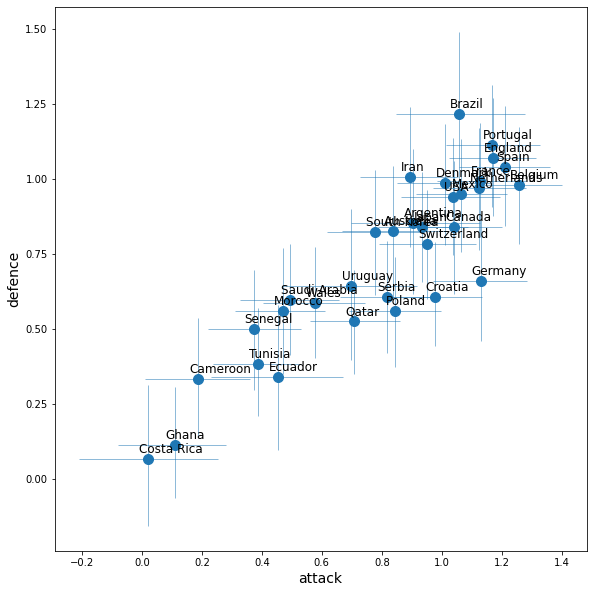

In [6]:
a_mean = wc_pred.model.attack.mean(axis=0)
b_mean = wc_pred.model.defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('attack', fontsize=14)
plt.ylabel('defence', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)

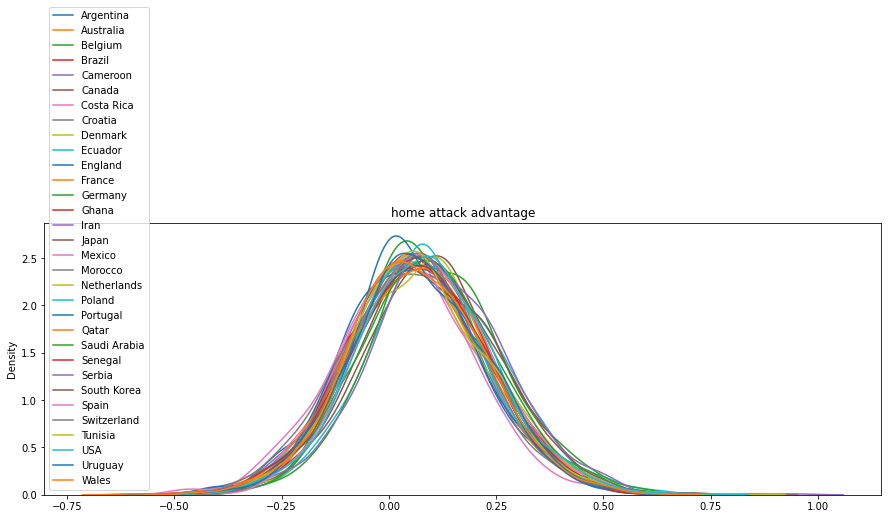

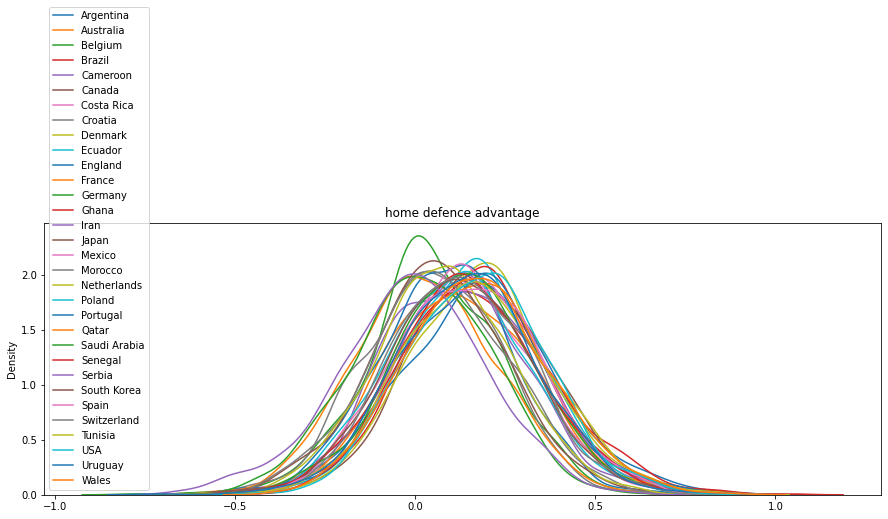

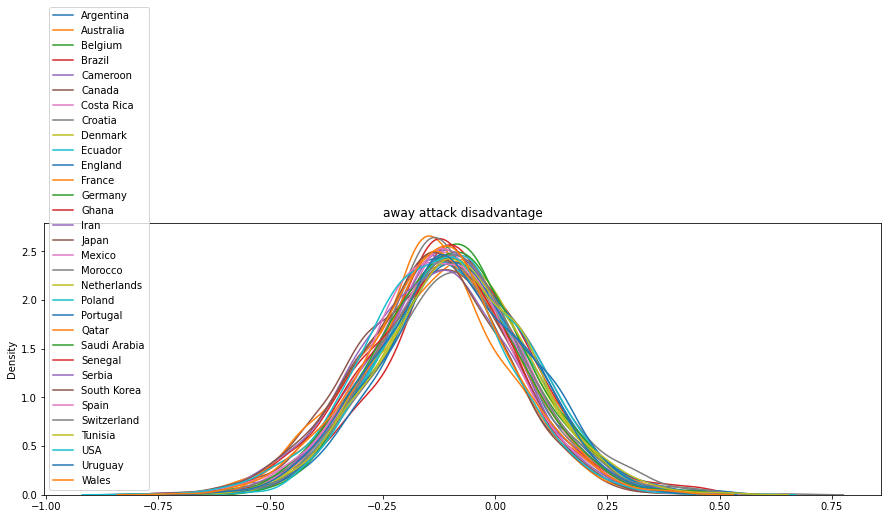

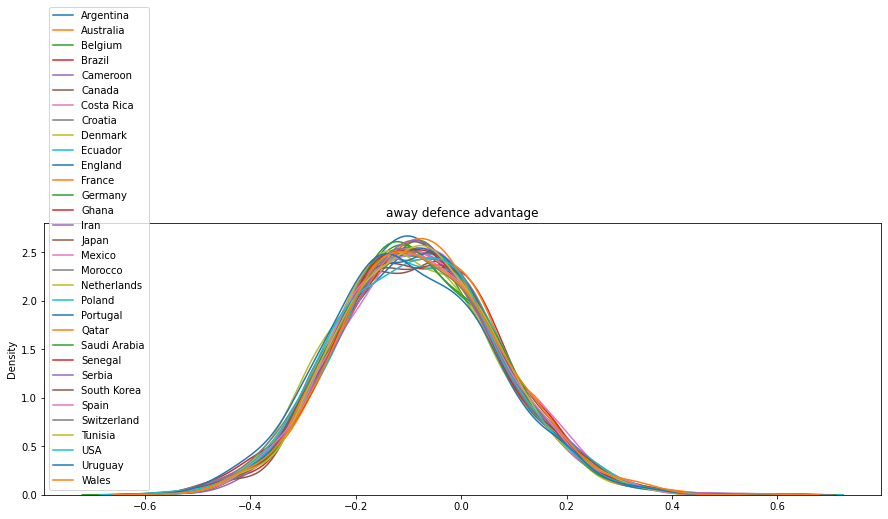

In [7]:
ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.home_attack[:, idx], label=team)
plt.title('home attack advantage')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.home_defence[:, idx], label=team)
plt.title('home defence advantage')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.away_attack[:, idx], label=team)
plt.title('away attack disadvantage')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.away_defence[:, idx], label=team)
plt.title('away defence advantage')
plt.legend()

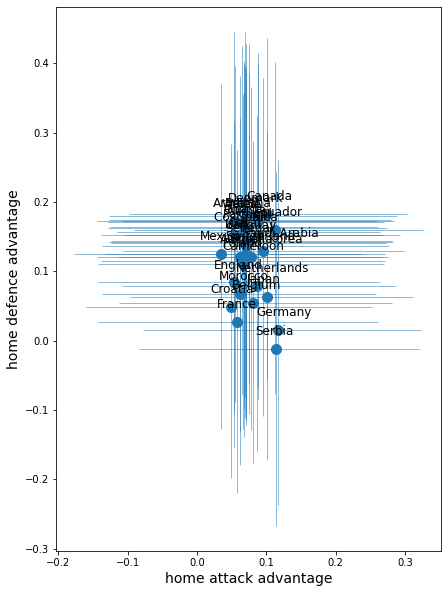

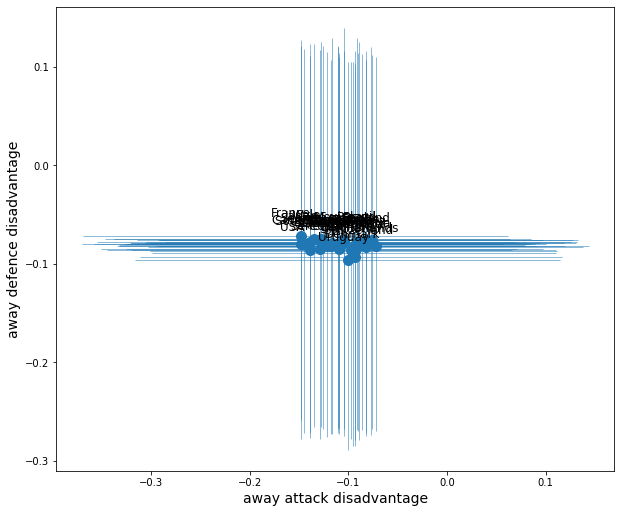

In [8]:
a_mean = wc_pred.model.home_attack.mean(axis=0)
b_mean = wc_pred.model.home_defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.home_attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.home_defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.home_attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.home_defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('home attack advantage', fontsize=14)
plt.ylabel('home defence advantage', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)

    
    
a_mean = wc_pred.model.away_attack.mean(axis=0)
b_mean = wc_pred.model.away_defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.away_attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.away_defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.away_attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.away_defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('away attack disadvantage', fontsize=14)
plt.ylabel('away defence disadvantage', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)


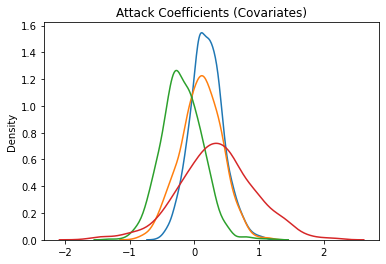

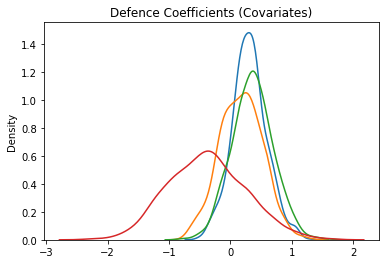

In [9]:
if wc_pred.model.attack_coefficients is not None:
    plt.figure()
    for i in range(wc_pred.model.attack_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.attack_coefficients[:, i])
    plt.title("Attack Coefficients (Covariates)")

    plt.figure()
    for i in range(wc_pred.model.defence_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.defence_coefficients[:, i])
    plt.title("Defence Coefficients (Covariates)")

## Using organisation rankings

In [10]:
wc_pred = wcpredictor.get_and_train_model(rankings_source="org")
dict(zip(sorted(list(set(wcpredictor.get_confederations_data()["Confederation"]))),
         wc_pred.model.confederation_strength.mean(axis=0).tolist()))

in get_and_train_model
Using FIFA organisation rankings
Using 3728 rows in training data
Using FIFA organisation rankings
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████████████████████████████████████████████| 1500/1500 [00:40<00:00, 37.31it/s, 63 steps of size 7.57e-02. acc. prob=0.87]


{'AFC': 0.039518434554338455,
 'CAF': 0.16066396236419678,
 'CONCACAF': -0.0013177457731217146,
 'CONMEBOL': 0.1855531930923462,
 'OFC': -0.14644944667816162,
 'UEFA': 0.20105059444904327}

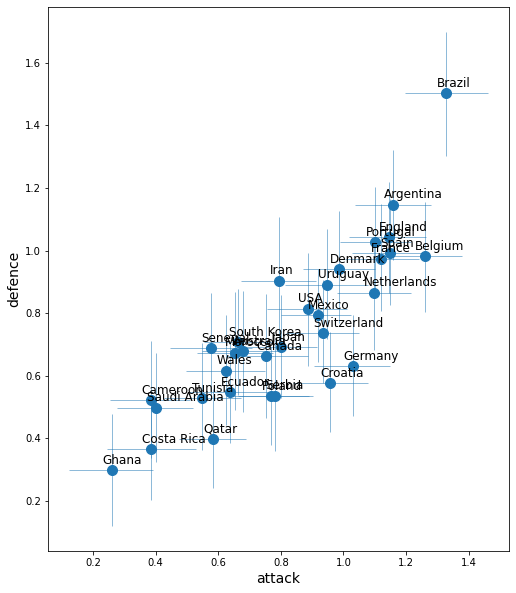

In [11]:
wc_teams_idx = {team: idx for idx, team in enumerate(wc_pred.model.teams)
                if team in wc_teams["Team"].values}
a_mean = wc_pred.model.attack.mean(axis=0)
b_mean = wc_pred.model.defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('attack', fontsize=14)
plt.ylabel('defence', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)

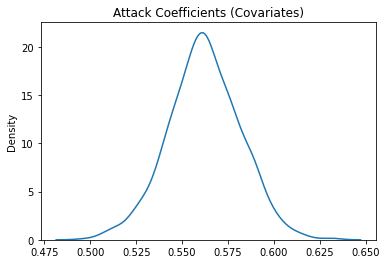

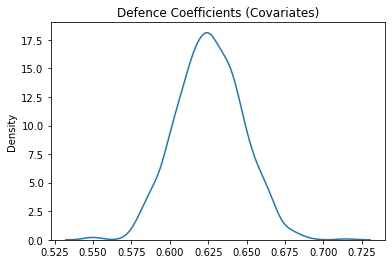

In [12]:
if wc_pred.model.attack_coefficients is not None:
    plt.figure()
    for i in range(wc_pred.model.attack_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.attack_coefficients[:, i])
    plt.title("Attack Coefficients (Covariates)")

    plt.figure()
    for i in range(wc_pred.model.defence_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.defence_coefficients[:, i])
    plt.title("Defence Coefficients (Covariates)")

## Use both Fifa organisation and Fifa game ratings

In [13]:
wc_pred = wcpredictor.get_and_train_model(rankings_source="both")
dict(zip(sorted(list(set(wcpredictor.get_confederations_data()["Confederation"]))),
         wc_pred.model.confederation_strength.mean(axis=0).tolist()))

in get_and_train_model
Using FIFA organisation rankings
Using 3728 rows in training data
Using FIFA videogame rankings
Using FIFA organisation rankings
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|███████████████████████████████████████████████| 1500/1500 [02:00<00:00, 12.49it/s, 255 steps of size 1.27e-02. acc. prob=0.94]


{'AFC': -0.06907730549573898,
 'CAF': 0.04774850234389305,
 'CONCACAF': -0.11165003478527069,
 'CONMEBOL': 0.09311702102422714,
 'OFC': -0.2984405755996704,
 'UEFA': 0.1223640963435173}

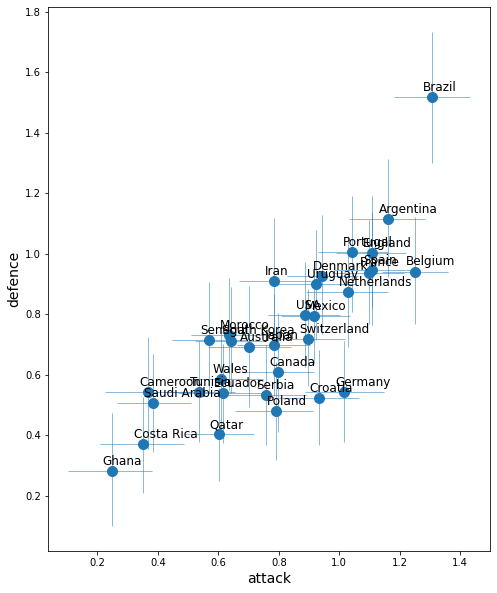

In [19]:
wc_teams_idx = {team: idx for idx, team in enumerate(wc_pred.model.teams)
                if team in wc_teams["Team"].values}
a_mean = wc_pred.model.attack.mean(axis=0)
b_mean = wc_pred.model.defence.mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.attack,[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.defence, [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.attack,[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.defence, [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('attack', fontsize=14)
plt.ylabel('defence', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)

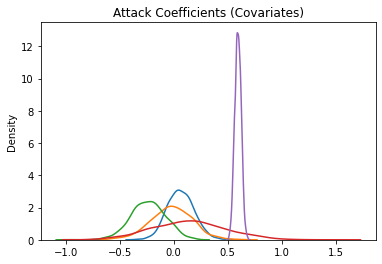

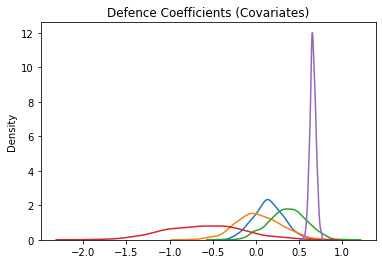

In [20]:
if wc_pred.model.attack_coefficients is not None:
    plt.figure()
    for i in range(wc_pred.model.attack_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.attack_coefficients[:, i])
    plt.title("Attack Coefficients (Covariates)")

    plt.figure()
    for i in range(wc_pred.model.defence_coefficients.shape[1]):
        sns.kdeplot(wc_pred.model.defence_coefficients[:, i])
    plt.title("Defence Coefficients (Covariates)")

# trying to hack away at Fifa default rankings for teams

In [16]:
confed_dict = dict(zip(wcpredictor.get_confederations_data().Team,
         wcpredictor.get_confederations_data().Confederation))
csv_path = "../wcpredictor/data/fifa_game_rankings.csv"
df =  pd.read_csv(csv_path)
# assign default values to teams not otherwise covered, use the same as Qatar
default_row = df.loc[df.Team=="Qatar"]
all_teams = wcpredictor.get_confederations_data().Team.unique()
current_teams = df.Team.unique()
new_teams = list(set(all_teams) - set(current_teams))

In [17]:
[team for team in new_teams if confed_dict[team] == "UEFA"]

['Belarus',
 'Slovenia',
 'Andorra',
 'Estonia',
 'Kosovo',
 'Latvia',
 'Moldova',
 'Turkey',
 'Luxembourg',
 'Slovakia',
 'Montenegro',
 'Bosnia and Herzegovina',
 'Malta',
 'San Marino',
 'Gibraltar',
 'Lithuania',
 'Greece',
 'Faroe Islands',
 'Azerbaijan',
 'Liechtenstein',
 'Russia',
 'Cyprus',
 'Israel',
 'Georgia',
 'Armenia',
 'North Macedonia',
 'Bulgaria',
 'Albania']

In [18]:
[team for team in new_teams if confed_dict[team] == "CONMEBOL"]

['Paraguay', 'Colombia', 'Bolivia', 'Venezuela']

In [ ]:
for conference in ["UEFA", "CAF"]:
    teams_in_conf = [team for team in new_teams if confed_dict[team] == conference]
    if conference == "UEFA":
        attribute = 2
    attack = 

In [45]:
test = []
test += [1,2]

In [46]:
00test

[1, 2]

In [38]:
[team for team in new_teams if confed_dict[team] == "CAF"]

['Eritrea',
 'Somalia',
 'Burkina Faso',
 'São Tomé and Príncipe',
 'Benin',
 'Rwanda',
 'Liberia',
 'Malawi',
 'Sudan',
 'Kenya',
 'Guinea-Bissau',
 'Zimbabwe',
 'South Africa',
 'Botswana',
 'Mozambique',
 'Uganda',
 'Angola',
 'Gabon',
 'Ivory Coast',
 'Eswatini',
 'Niger',
 'Mauritius',
 'Togo',
 'Seychelles',
 'Libya',
 'Madagascar',
 'Mali',
 'Egypt',
 'Burundi',
 'Nigeria',
 'DR Congo',
 'Chad',
 'Central African Republic',
 'Algeria',
 'Comoros',
 'Equatorial Guinea',
 'Mauritania',
 'Tanzania',
 'Djibouti',
 'Cape Verde',
 'Lesotho',
 'South Sudan',
 'Sierra Leone',
 'Namibia',
 'Guinea',
 'Ethiopia',
 'Zambia',
 'Congo',
 'Gambia']

In [39]:
[team for team in new_teams if confed_dict[team] == "AFC"]

['Vietnam',
 'Guam',
 'Kyrgyzstan',
 'United Arab Emirates',
 'Bahrain',
 'Palestine',
 'Iraq',
 'Kazakhstan',
 'Syria',
 'Turkmenistan',
 'Tajikistan',
 'Bhutan',
 'Hong Kong',
 'North Korea',
 'Malaysia',
 'Maldives',
 'Philippines',
 'Pakistan',
 'Laos',
 'Cambodia',
 'Timor-Leste',
 'Yemen',
 'Bangladesh',
 'Mongolia',
 'Afghanistan',
 'Sri Lanka',
 'Oman',
 'Kuwait',
 'Indonesia',
 'Lebanon',
 'Thailand',
 'India',
 'Nepal',
 'Brunei Darussalam',
 'Jordan',
 'Taiwan',
 'Myanmar',
 'Macau',
 'Singapore',
 'Uzbekistan']

In [14]:
[team for team in new_teams if confed_dict[team] == "AFC"]

['Mongolia',
 'Kuwait',
 'Lebanon',
 'Philippines',
 'Bahrain',
 'Nepal',
 'Kyrgyzstan',
 'Taiwan',
 'Maldives',
 'Brunei Darussalam',
 'India',
 'United Arab Emirates',
 'Iraq',
 'Bangladesh',
 'Myanmar',
 'Malaysia',
 'Cambodia',
 'Timor-Leste',
 'Yemen',
 'Sri Lanka',
 'Jordan',
 'Uzbekistan',
 'Bhutan',
 'Macau',
 'Hong Kong',
 'Pakistan',
 'Laos',
 'Tajikistan',
 'Afghanistan',
 'Guam',
 'Thailand',
 'Turkmenistan',
 'Vietnam',
 'Syria',
 'North Korea',
 'Singapore',
 'Palestine',
 'Kazakhstan',
 'Indonesia',
 'Oman']

In [41]:
df.loc[df.Team=="China PR"]

,Team,Attack,Midfield,Defence,Overall
46,China PR,68,68,67,68


In [ ]:
pd.DataFrame({a})

In [36]:
len(new_teams)

164

In [34]:
pd.Series([confed_dict[team] for team in new_teams]).value_counts()

CAF         49
AFC         40
CONCACAF    31
UEFA        28
OFC         10
CONMEBOL     6
dtype: int64

In [ ]:
# need to give the "worst" team in their conference

In [ ]:
self.conferences_ref = dict(zip(range(len(self.conferences)), self.conferences))

In [26]:
wcpredictor.get_confederations_data()

,Team,Confederation
0,India,AFC
1,Thailand,AFC
2,North Korea,AFC
3,Kazakhstan,AFC
4,Philippines,AFC
...,...,...
206,Moldova,UEFA
207,Hungary,UEFA
208,Azerbaijan,UEFA
209,Netherlands,UEFA


In [42]:
set(wcpredictor.get_confederations_data().Confederation)

{'AFC', 'CAF', 'CONCACAF', 'CONMEBOL', 'OFC', 'UEFA'}

In [9]:
confed_dict["Estonia"]

'UEFA'

## Dynamic Model

In [11]:
def add_gameweek_index(df):
    earliest_date = df["date"].min()
    latest_date = df["date"].max()
    month, year = earliest_date.month, earliest_date.year
    end_month, end_year = latest_date.month, latest_date.year
    gameweek_index = 1
    while pd.Timestamp(f"{year}-{month}-01") <= latest_date:
        month_cond = df["date"].dt.month == month
        year_cond = df["date"].dt.year == year
        df.loc[month_cond & year_cond, "gameweek"] = gameweek_index
        if month < 12:
            month += 1
        else:
            month = 1
            year += 1
        gameweek_index += 1
    df["gameweek"] = df["gameweek"].astype(int)
    return df

results = add_gameweek_index(results)

In [12]:
wc_pred = wcpredictor.WCPred(results = results, ratings=fifa_rankings)

In [13]:
wc_pred.fit_model(dynamic=True)

[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample:  82%|█████████████████████████████████████▉        | 1237/1500 [33:36<07:08,  1.63s/it, 1023 steps of size 5.45e-04. acc. prob=0.83]


KeyboardInterrupt: 

In [ ]:
wc_teams_idx = {team: idx for idx, team in enumerate(wc_pred.model.teams)
                if team in wc_teams["Team"].values}

In [ ]:
wc_pred.model.attack[51]

In [ ]:
ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.attack[56][:, idx], label=team)
plt.title('attack')
plt.legend()

ax = plt.figure(figsize=(15, 5)).gca()
for team, idx in wc_teams_idx.items():
    sns.kdeplot(wc_pred.model.defence[56][:, idx], label=team)
plt.title('defence')
plt.legend()

In [ ]:
a_mean = wc_pred.model.attack[56].mean(axis=0)
b_mean = wc_pred.model.defence[56].mean(axis=0)

a_conf95 = np.abs(np.quantile(wc_pred.model.attack[56],[0.025, 0.975], axis=0) - a_mean)
b_conf95 = np.abs(np.quantile(wc_pred.model.defence[56], [0.025, 0.975], axis=0) - b_mean)
a_conf80 = np.abs(np.quantile(wc_pred.model.attack[56],[0.1, 0.9], axis=0) - a_mean)
b_conf80 = np.abs(np.quantile(wc_pred.model.defence[56], [0.1, 0.9], axis=0) - b_mean)

fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.set_aspect('equal')
select_idx = np.array(list(wc_teams_idx.values()), dtype=int)
plt.errorbar(a_mean[select_idx],
             b_mean[select_idx],
             xerr=a_conf80[:, select_idx],
             yerr=b_conf80[:, select_idx],
             marker='o', markersize=10,
             linestyle='', linewidth=0.5)
plt.xlabel('attack', fontsize=14)
plt.ylabel('defence', fontsize=14)

for team, idx in wc_teams_idx.items():
    ax.annotate(team,
                (a_mean[idx]-0.03, b_mean[idx]+0.02), 
                fontsize=12)

## Try Including More Years (but without FIFA rankings)

- fit up to end of 2020
- test on 2021 and 2022

In [45]:
results = pd.read_csv('../data/results.csv', parse_dates=['date'])
results.rename(columns={"neutral": "neutral_venue"}, inplace=True)


def filter_results(year_from, year_until, teams=None):
    r = results[(results.date.dt.year >= year_from) & (results.date.dt.year <= year_until)]
    if teams:
        r = r[(r["home_team"].isin(teams)) & (r["away_team"].isin(teams))]
    return r

def fit_model_between(year_from, year_until):
    r = filter_results(year_from, year_until)
    wc_pred = WCPred(results = r)
    wc_pred.fit_model()
    return wc_pred.model


def test_model_between(model, year_from, year_until):
    r = filter_results(year_from, year_until, model.teams)
    proba = model.predict_score_proba(
        np.array(r["home_team"]),
        np.array(r["away_team"]),
        np.array(r["home_score"]),
        np.array(r["away_score"]),
        np.array(r["neutral_venue"]),
    )
    return np.log(proba).sum() / len(proba)  # log likelihood


1872
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [03:46<00:00,  6.62it/s, 63 steps of size 8.28e-02. acc. prob=0.88]


1900
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [03:53<00:00,  6.42it/s, 63 steps of size 9.18e-02. acc. prob=0.88]


1925
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|███████| 1500/1500 [05:08<00:00,  4.86it/s, 127 steps of size 4.90e-02. acc. prob=0.92]


1950
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [03:29<00:00,  7.17it/s, 63 steps of size 7.63e-02. acc. prob=0.89]


1975
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [02:57<00:00,  8.44it/s, 63 steps of size 6.57e-02. acc. prob=0.92]


2000
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [01:27<00:00, 17.06it/s, 31 steps of size 1.16e-01. acc. prob=0.89]


2004
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [01:18<00:00, 19.13it/s, 31 steps of size 1.18e-01. acc. prob=0.87]


2008
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:54<00:00, 27.60it/s, 31 steps of size 1.38e-01. acc. prob=0.85]


2010
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:47<00:00, 31.41it/s, 31 steps of size 1.51e-01. acc. prob=0.85]


2011
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:47<00:00, 31.79it/s, 31 steps of size 1.59e-01. acc. prob=0.84]


2012
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:40<00:00, 36.88it/s, 31 steps of size 1.46e-01. acc. prob=0.86]


2013
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:37<00:00, 39.62it/s, 31 steps of size 1.53e-01. acc. prob=0.85]


2014
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:33<00:00, 45.31it/s, 31 steps of size 1.86e-01. acc. prob=0.80]


2015
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:31<00:00, 47.17it/s, 31 steps of size 1.33e-01. acc. prob=0.86]


2016
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:27<00:00, 55.40it/s, 31 steps of size 1.27e-01. acc. prob=0.92]


2017
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:26<00:00, 57.59it/s, 31 steps of size 1.43e-01. acc. prob=0.90]


2018
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:19<00:00, 76.39it/s, 31 steps of size 1.23e-01. acc. prob=0.92]


2019
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|████████| 1500/1500 [00:16<00:00, 92.20it/s, 31 steps of size 1.60e-01. acc. prob=0.87]


2020
[MODEL FITTING] Setting training data for the model
[MODEL FITTING] Fitting the model


sample: 100%|███████| 1500/1500 [00:08<00:00, 166.98it/s, 31 steps of size 1.37e-01. acc. prob=0.92]


Text(0, 0.5, 'likelihood')

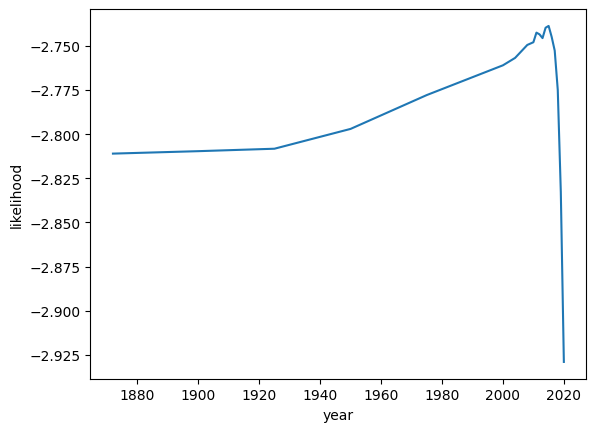

In [47]:
years = [
    1872, 1900, 1925, 1950, 1975, 2000,
    2004, 2008, 2010, 2011, 2012, 2013,
    2014, 2015, 2016, 2017, 2018, 2019,
    2020
]
train_until = 2020
test_from = 2021
test_until = 2022

likelihoods = []

for y in years:
    print("=======")
    print(y)
    print("=======")
    model = fit_model_between(y, train_until)
    likelihoods.append(test_model_between(model, test_from, test_until))


Text(0, 0.5, 'log likelihood (2021 - 2022)')

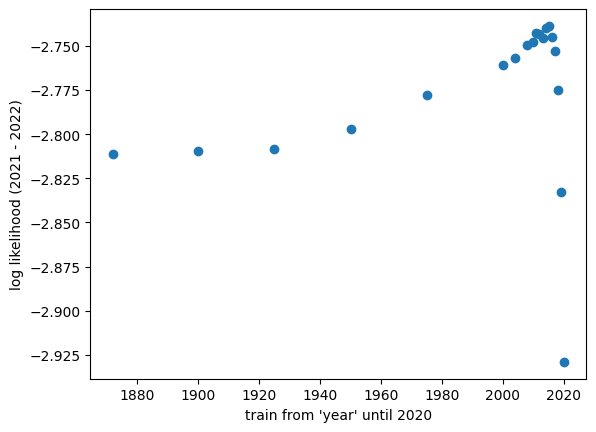

In [58]:
plt.plot(years, likelihoods, "o")
plt.xlabel(f"train from 'year' until {train_until}")
plt.ylabel(f"log likelihood ({test_from} - {test_until})")

In [50]:
pd.Series(likelihoods, index=years)

1872   -2.810997
1900   -2.809613
1925   -2.808227
1950   -2.796989
1975   -2.777815
2000   -2.760951
2004   -2.756748
2008   -2.749413
2010   -2.747872
2011   -2.742429
2012   -2.743396
2013   -2.745532
2014   -2.739667
2015   -2.738628
2016   -2.744843
2017   -2.752637
2018   -2.774900
2019   -2.832764
2020   -2.929056
dtype: float64

Max likelihood at 2015, i.e. when training with 6 full years of data.

So for World Cup 2022 may want to include 2016-2022 results.